In [188]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
 

df = pd.read_csv("data/train.csv")

df["Name"].str.split(',').str.get(1).str.split('.').str.get(0)

0         Mr
1        Mrs
2       Miss
3        Mrs
4         Mr
       ...  
886      Rev
887     Miss
888     Miss
889       Mr
890       Mr
Name: Name, Length: 891, dtype: object

In [148]:
def show_accuracy_confusion(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    print("Accuracy: " + str(accuracy_score(y_test, predictions)))
    ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()    

In [149]:
def fill_values(df):
    
    #probably children
    #df.loc[(df["SibSp"] > 2) & pd.isna(df["Age"])] = df.loc[(df["SibSp"] > 2) & pd.isna(df["Age"])].fillna(value=10)

    df["Age"] = df.groupby("Pclass")["Age"].transform(lambda x: x.fillna(x.median()))

In [150]:
X = df.drop(["PassengerId", "Survived", "Name", "Embarked"], axis="columns")
y = df["Survived"]

fill_values(X)

In [151]:
X_enc = pd.get_dummies(X, columns = ["Pclass", "Sex"])

has_cabin = [int(pd.isna(cabin)) for cabin in X_enc["Cabin"]]
#X_enc["has cabin"] = has_cabin

X_enc["deck"] = X_enc["Cabin"].str.get(0)
X_enc = pd.get_dummies(X_enc, columns=["deck"])

X_enc = X_enc.drop(["Cabin", "Ticket", "deck_T"], axis = "columns")
#X_enc.head()


In [153]:
X_enc.head(10)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,0,0,0,0,0
1,38.0,1,0,71.2833,1,0,0,1,0,0,0,1,0,0,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,0,0,0,0,0
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0,0,0,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,0,0,0,0,0
5,24.0,0,0,8.4583,0,0,1,0,1,0,0,0,0,0,0,0
6,54.0,0,0,51.8625,1,0,0,0,1,0,0,0,0,1,0,0
7,2.0,3,1,21.0750,0,0,1,0,1,0,0,0,0,0,0,0
8,27.0,0,2,11.1333,0,0,1,1,0,0,0,0,0,0,0,0
9,14.0,1,0,30.0708,0,1,0,1,0,0,0,0,0,0,0,0


In [154]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=22, test_size=0.25)

Accuracy: 0.7713004484304933


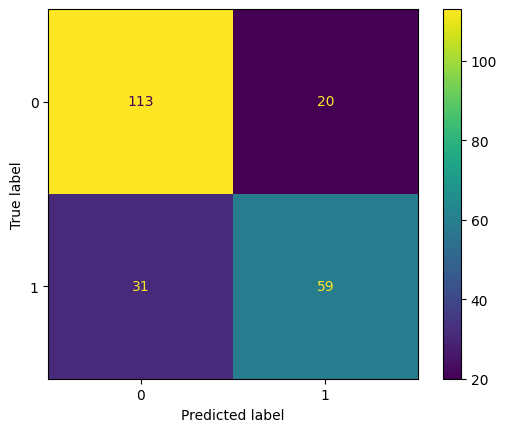

In [155]:
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

show_accuracy_confusion(pipe, X_test, y_test)

In [156]:
forest = RandomForestClassifier(criterion="entropy", max_depth=5, n_estimators=300)
sgd = SGDClassifier(eta0=1, learning_rate="adaptive",n_jobs=-1, penalty="l2", loss="log_loss")
svc = SVC(kernel="rbf", gamma=0.01, C = 3)

for model in [forest, sgd, svc]:
    model.fit(X_train, y_train)

Accuracy: 0.7937219730941704


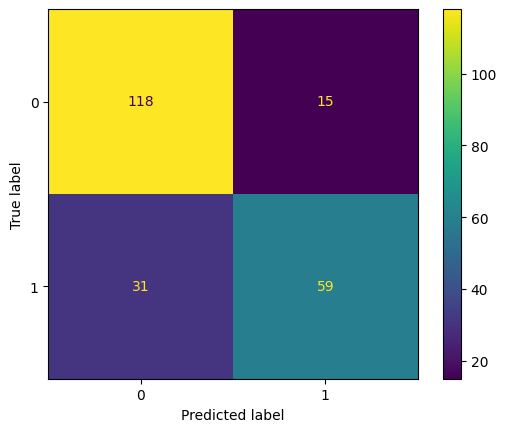

In [157]:
show_accuracy_confusion(forest, X_test, y_test)

Accuracy: 0.7757847533632287


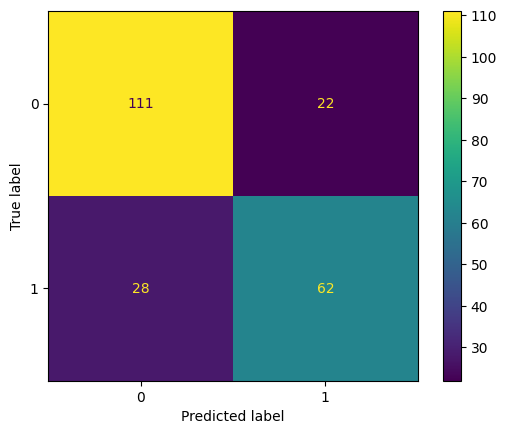

In [158]:
show_accuracy_confusion(sgd, X_test, y_test)

Accuracy: 0.7802690582959642


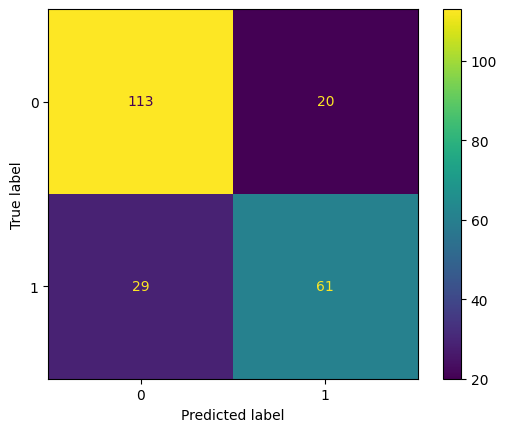

In [159]:
show_accuracy_confusion(svc, X_test, y_test)

In [38]:
forest_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier())
])

forest_grid = {
    "forest__n_estimators": [300, 350, 400],
    "forest__max_depth": [3, 5, 6, None],
    "forest__criterion": ["gini", "entropy"],
}

forcv = GridSearchCV(estimator=forest_pipe, param_grid=forest_grid, cv = 10, scoring="accuracy")

forcv.fit(X_train, y_train)
forcv.best_params_

KeyboardInterrupt: 

Accuracy: 0.7873134328358209


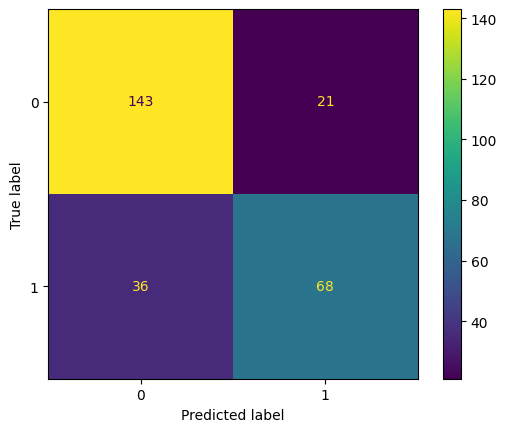

In [ ]:
show_accuracy_confusion(forcv, X_test, y_test)

In [ ]:
sgd_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDClassifier())
])

sgd_params = {
    "sgd__loss": ["hinge", "log_loss", "perceptron", "modified_huber"],
    "sgd__penalty": ["l2", "elasticnet"],
    "sgd__learning_rate": ["optimal", "adaptive"],
    "sgd__n_jobs": [-1],
    "sgd__eta0" :[1]
    
}

sgd_opt = GridSearchCV(estimator=sgd_pipe, cv=10, scoring="accuracy", param_grid=sgd_params)
sgd_opt.fit(X_train, y_train)
sgd_opt.best_params_

{'sgd__eta0': 1,
 'sgd__learning_rate': 'adaptive',
 'sgd__loss': 'modified_huber',
 'sgd__n_jobs': -1,
 'sgd__penalty': 'l2'}

Accuracy: 0.7761194029850746


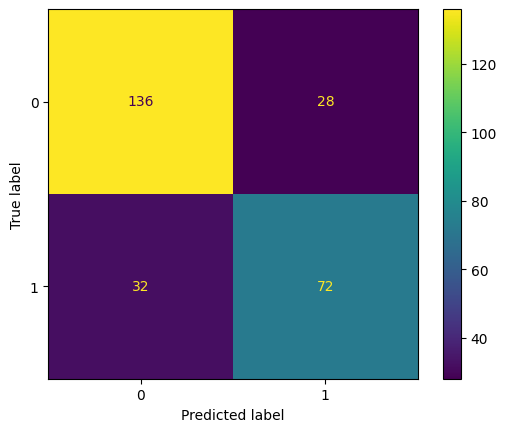

In [ ]:
show_accuracy_confusion(sgd_opt, X_test, y_test)